In [1]:
# load libaries
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns

# set option for pandas to display all columns
pd.set_option('display.max_columns', 500)

In [2]:
# load data from GitHub

url = 'https://raw.githubusercontent.com/SportsInfoSolutions/AnalyticsChallenge2020/master/Data/AnalyticsChallenge2020Data.csv'
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74012 entries, 0 to 74011
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GameID              74012 non-null  int64  
 1   EventID             74012 non-null  int64  
 2   Season              74012 non-null  int64  
 3   Week                74012 non-null  int64  
 4   StadiumName         74012 non-null  object 
 5   OffensiveTeam       74012 non-null  object 
 6   DefensiveTeam       74012 non-null  object 
 7   OffTeamScoreBefore  74012 non-null  int64  
 8   DefTeamScoreBefore  74012 non-null  int64  
 9   Quarter             74012 non-null  int64  
 10  TimeLeft            74012 non-null  int64  
 11  Down                74012 non-null  int64  
 12  ToGo                74012 non-null  int64  
 13  SideOfField         74012 non-null  object 
 14  StartYard           74012 non-null  int64  
 15  EventType           74012 non-null  object 
 16  Firs

# Add columns related to game situation

In [4]:
# time left in game
# 15 minutes per quarter = 900 seconds
def time_left(quarter, time):
    if quarter == 1:
        return time + 900*3
    elif quarter == 2:
        return time + 900*2
    elif quarter == 3:
        return time + 900
    else:
        return time
    
# create lists for player types

NT = ['0','1']
DT = ['2','2i','3']
DE = ['4','4i','5','7']
EDGE = ['6','9','Outside','Off Ball']


# create function to map player types based on technique
def position_name(t):
    if t in NT:
        return 'NT'
    elif t in DT:
        return 'DT'
    elif t in DE:
        return 'DE'
    else:
        return 'EDGE'       

In [5]:
#function that will clean up the entire data set

def clean_data(data):
    data.drop(data[data['Spike'] == 1].index, inplace = True)
    data['EventType'].replace({'challenge pass':'pass', 'challenge rush':'rush'}, inplace = True)
    data['dEPA'] = data['EPA']*-1
    data['score_diff'] = data['DefTeamScoreBefore'] - data['OffTeamScoreBefore']
    data['YardsToEndzone'] = data.apply(lambda x: 100-x['StartYard'] if x['SideOfField'] == 'Own' else x['StartYard'], axis = 1)
    data['game_sec_left'] = data.apply(lambda x: time_left(x['Quarter'], x['TimeLeft']), axis = 1)
    data['play_pos'] = data.apply(lambda x: position_name(x['TechniqueName']), axis = 1)
    return data


In [6]:
# create final data set to work with
play_data = clean_data(df)

# Look at aggregate data for each position

In [7]:
dl_sum = play_data.groupby('play_pos').agg({'EventID':'count','PlayerId':'nunique','dEPA':'sum','SoloSack':'sum','AssistedSack':'sum', 'Pressure':'sum', 'PassBreakup':'sum','ForcedFumble':'sum'}).reset_index()

In [8]:
dl_sum

,play_pos,EventID,PlayerId,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,12919,302,541.090538,78,21,688,28,17
1,DT,19377,286,452.362025,92,14,701,57,8
2,EDGE,32562,602,918.890751,291,54,2020,112,74
3,NT,9015,217,269.010799,26,15,278,18,5


In [9]:
dl_mean = play_data.groupby('play_pos').agg({'EventID':'nunique','dEPA':'mean','SoloSack':'mean','AssistedSack':'mean', 'Pressure':'mean', 'PassBreakup':'mean','ForcedFumble':'mean'}).reset_index()

In [10]:
# update dl_mean figures to be per 60 plays

dl_mean['dEPA'] = dl_mean['dEPA']*60
dl_mean['SoloSack'] = dl_mean['SoloSack']*60
dl_mean['AssistedSack'] = dl_mean['AssistedSack']*60
dl_mean['Pressure'] = dl_mean['Pressure']*60
dl_mean['PassBreakup'] = dl_mean['PassBreakup']*60
dl_mean['ForcedFumble'] = dl_mean['ForcedFumble']*60

In [11]:
dl_mean

,play_pos,EventID,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,217,2.512999,0.362257,0.097531,3.195294,0.130041,0.078953
1,DT,227,1.400863,0.284874,0.043350,2.170615,0.176498,0.024772
2,EDGE,234,1.693340,0.536208,0.099502,3.722130,0.206376,0.136355
3,NT,219,1.790421,0.173045,0.099834,1.850250,0.119800,0.033278


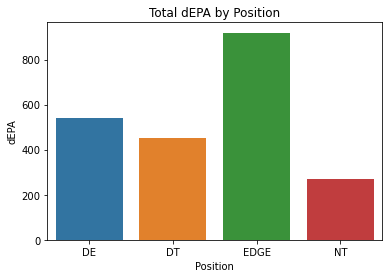

In [12]:
# plot total players and dEPA

sns.barplot(x = 'play_pos', y = 'dEPA', data = dl_sum)
plt.xlabel('Position')
plt.title('Total dEPA by Position')
plt.show()


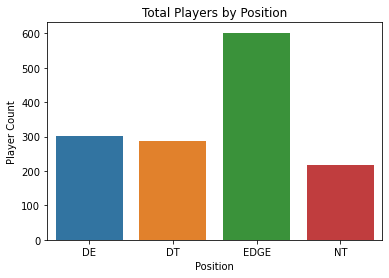

In [13]:
sns.barplot(x = 'play_pos', y = 'PlayerId', data = dl_sum)
plt.xlabel('Position')
plt.ylabel('Player Count')
plt.title('Total Players by Position')
plt.show()

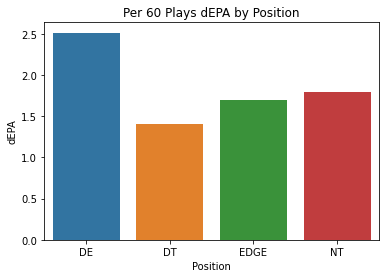

In [52]:
# plot dEPA per play

sns.barplot(x = 'play_pos', y = 'dEPA', data = dl_mean)
plt.xlabel('Position')
plt.title('Per 60 Plays dEPA by Position')
plt.show()


# Game Situation Analysis

# Passing plays

In [14]:
# passing situations
passing = play_data.loc[play_data['EventType'] == 'pass']
passing_mean = passing.groupby('play_pos').agg({'EventID':'nunique','dEPA':'mean','SoloSack':'mean','AssistedSack':'mean', 'Pressure':'mean', 'PassBreakup':'mean','ForcedFumble':'mean'}).reset_index()
passing_totals = passing.groupby('play_pos').agg({'EventID':'count','PlayerId':'nunique','dEPA':'sum','SoloSack':'sum','AssistedSack':'sum', 'Pressure':'sum', 'PassBreakup':'sum','ForcedFumble':'sum'}).reset_index()

In [15]:
# update mean values to be per 60 plays
passing_mean['dEPA'] = passing_mean['dEPA']*60
passing_mean['SoloSack'] = passing_mean['SoloSack']*60
passing_mean['AssistedSack'] = passing_mean['AssistedSack']*60
passing_mean['Pressure'] = passing_mean['Pressure']*60
passing_mean['PassBreakup'] = passing_mean['PassBreakup']*60
passing_mean['ForcedFumble'] = passing_mean['ForcedFumble']*60

In [16]:
passing_mean

,play_pos,EventID,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,211,2.497266,0.637950,0.171756,5.308070,0.229008,0.098146
1,DT,216,0.166172,0.523669,0.079689,3.773835,0.324447,0.028460
2,EDGE,224,0.846862,0.903540,0.167667,5.927344,0.347754,0.186297
3,NT,211,0.209233,0.335340,0.193465,3.353396,0.232158,0.025795


In [17]:
passing_totals

,play_pos,EventID,PlayerId,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,7336,290,305.332367,78,21,649,28,12
1,DT,10541,268,29.188166,92,14,663,57,5
2,EDGE,19324,539,272.703817,291,54,1909,112,60
3,NT,4652,206,16.222560,26,15,260,18,2


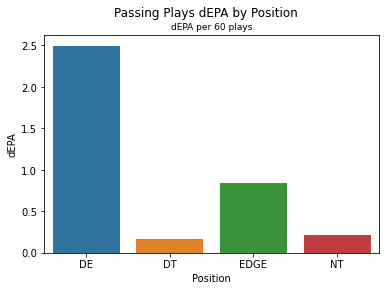

In [18]:
sns.barplot(x = 'play_pos', y = 'dEPA', data = passing_mean)
plt.xlabel('Position')
plt.suptitle('Passing Plays dEPA by Position', fontsize = 12)
plt.title('dEPA per 60 plays', fontsize = 9, y = 1)
plt.show()

# Rushing Plays

In [19]:
# passing situations
rushing = play_data.loc[play_data['EventType'] == 'rush']
rushing_mean = rushing.groupby('play_pos').agg({'EventID':'nunique','dEPA':'mean','Pressure':'mean', 'ForcedFumble':'mean'}).reset_index()
rushing_totals = rushing.groupby('play_pos').agg({'EventID':'count','PlayerId':'nunique','dEPA':'sum','Pressure':'sum', 'PassBreakup':'sum'}).reset_index()

In [20]:
# update mean values to be per 60 plays
rushing_mean['dEPA'] = rushing_mean['dEPA']*60
rushing_mean['Pressure'] = rushing_mean['Pressure']*60
rushing_mean['ForcedFumble'] = rushing_mean['ForcedFumble']*60

In [21]:
rushing_mean

,play_pos,EventID,dEPA,Pressure,ForcedFumble
0,DE,201,2.533672,0.419130,0.053735
1,DT,210,2.873521,0.258035,0.020371
2,EDGE,210,2.928782,0.503097,0.063454
3,NT,204,3.476345,0.247536,0.041256


In [22]:
rushing_totals

,play_pos,EventID,PlayerId,dEPA,Pressure,PassBreakup
0,DE,5583,267,235.758171,39,0
1,DT,8836,262,423.173859,38,0
2,EDGE,13238,529,646.186934,111,0
3,NT,4363,185,252.788239,18,0


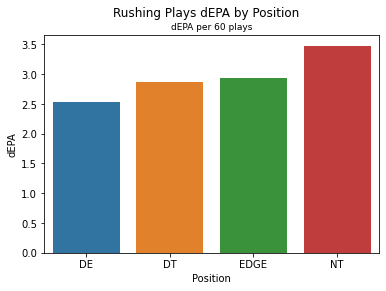

In [37]:
sns.barplot(x = 'play_pos', y = 'dEPA', data = rushing_mean)
plt.xlabel('Position')
plt.suptitle('Rushing Plays dEPA by Position', fontsize = 12)
plt.title('dEPA per 60 plays', fontsize = 9, y = 1)
plt.show()

# Short Yardage

In [23]:
short_yard = play_data.loc[play_data['ToGo'] <= 3]
short_yard_mean = short_yard.groupby('play_pos').agg({'EventID':'nunique','dEPA':'mean','SoloSack':'mean','AssistedSack':'mean', 'Pressure':'mean', 'PassBreakup':'mean','ForcedFumble':'mean'}).reset_index()
short_yard_totals = short_yard.groupby('play_pos').agg({'EventID':'count','PlayerId':'nunique','dEPA':'sum','SoloSack':'sum','AssistedSack':'sum', 'Pressure':'sum', 'PassBreakup':'sum','ForcedFumble':'sum'}).reset_index()

In [24]:
short_yard_mean['dEPA'] = short_yard_mean['dEPA']*60
short_yard_mean['SoloSack'] = short_yard_mean['SoloSack']*60
short_yard_mean['AssistedSack'] = short_yard_mean['AssistedSack']*60
short_yard_mean['Pressure'] = short_yard_mean['Pressure']*60
short_yard_mean['PassBreakup'] = short_yard_mean['PassBreakup']*60
short_yard_mean['ForcedFumble'] = short_yard_mean['ForcedFumble']*60

In [25]:
short_yard_mean

,play_pos,EventID,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,192,4.119075,0.368921,0.134153,2.347680,0.134153,0.134153
1,DT,193,1.601573,0.190024,0.000000,1.472684,0.118765,0.023753
2,EDGE,198,2.194900,0.308916,0.042125,2.471332,0.224667,0.098292
3,NT,194,1.413505,0.086207,0.086207,0.991379,0.129310,0.043103


In [26]:
short_yard_totals

,play_pos,EventID,PlayerId,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,1789,246,122.817101,11,4,70,4,4
1,DT,2526,247,67.426206,8,0,62,5,1
2,EDGE,4273,440,156.313486,22,3,176,16,7
3,NT,1392,161,32.793322,2,2,23,3,1


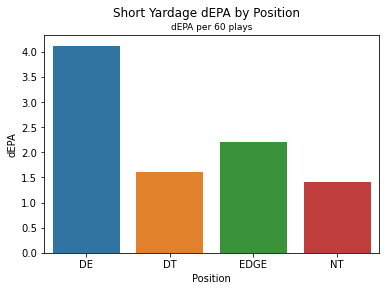

In [38]:
sns.barplot(x = 'play_pos', y = 'dEPA', data = short_yard_mean)
plt.xlabel('Position')
plt.suptitle('Short Yardage dEPA by Position', fontsize = 12)
plt.title('dEPA per 60 plays', fontsize = 9, y = 1)
plt.show()

# Passing Situations

In [32]:
passing_sit = play_data.loc[((play_data['Down'] == 1) & (play_data['ToGo'] >= 15))\
                            | ((play_data['Down'] == 2) & (play_data['ToGo'] >= 10))\
                            | ((play_data['Down'] >= 3) & (play_data['ToGo'] >= 5))]
passing_sit_mean = passing_sit.groupby('play_pos').agg({'EventID':'nunique','dEPA':'mean','SoloSack':'mean','AssistedSack':'mean', 'Pressure':'mean', 'PassBreakup':'mean','ForcedFumble':'mean'}).reset_index()
passing_sit_totals = passing_sit.groupby('play_pos').agg({'EventID':'count','PlayerId':'nunique','dEPA':'sum','SoloSack':'sum','AssistedSack':'sum', 'Pressure':'sum', 'PassBreakup':'sum','ForcedFumble':'sum'}).reset_index()

In [33]:
passing_sit_mean['dEPA'] = passing_sit_mean['dEPA']*60
passing_sit_mean['SoloSack'] = passing_sit_mean['SoloSack']*60
passing_sit_mean['AssistedSack'] = passing_sit_mean['AssistedSack']*60
passing_sit_mean['Pressure'] = passing_sit_mean['Pressure']*60
passing_sit_mean['PassBreakup'] = passing_sit_mean['PassBreakup']*60
passing_sit_mean['ForcedFumble'] = passing_sit_mean['ForcedFumble']*60

In [34]:
passing_sit_mean

,play_pos,EventID,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,201,5.660308,0.558391,0.162113,5.043530,0.252177,0.054038
1,DT,205,4.791444,0.467186,0.080089,3.563960,0.360400,0.026696
2,EDGE,211,4.320784,0.894589,0.181420,5.667814,0.294026,0.212699
3,NT,203,4.893013,0.241327,0.150830,3.499246,0.180995,0.000000


In [35]:
passing_sit_totals

,play_pos,EventID,PlayerId,dEPA,SoloSack,AssistedSack,Pressure,PassBreakup,ForcedFumble
0,DE,3331,265,314.241445,31,9,280,14,3
1,DT,4495,249,358.958979,35,6,267,27,2
2,EDGE,9591,454,690.677246,143,29,906,47,34
3,NT,1989,187,162.203393,8,5,116,6,0


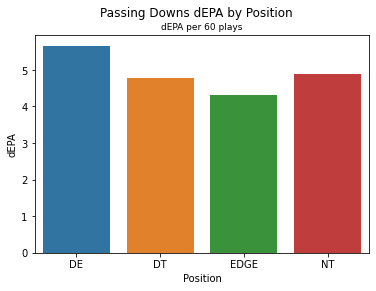

In [36]:
sns.barplot(x = 'play_pos', y = 'dEPA', data = passing_sit_mean)
plt.xlabel('Position')
plt.suptitle('Passing Downs dEPA by Position', fontsize = 12)
plt.title('dEPA per 60 plays', fontsize = 9, y = 1)
plt.show()